### REFERENCES 

Text classification using CNN with tensorflow 2.1 in python #NLP #tutorial (2020) YouTube. Available at: https://www.youtube.com/watch?v=MsL79ZIqWpg (Accessed: 17 September 2023). 

Text classification using neural network | google colab (2020) YouTube. Available at: https://www.youtube.com/watch?v=QE6-FMiRajQ (Accessed: 17 September 2023). 

Ahamed, S. (2018) Text classification using CNN, LSTM and visualize word embeddings: Part-2, Medium. Available at: https://sabber.medium.com/classifying-yelp-review-comments-using-cnn-lstm-and-visualize-word-embeddings-part-2-ca137a42a97d (Accessed: 17 September 2023). 

@article{joulin2016bag,
  title={Bag of Tricks for Efficient Text Classification},
  author={Joulin, Armand and Grave, Edouard and Bojanowski, Piotr and Mikolov, Tomas},
  journal={arXiv preprint arXiv:1607.01759},
  year={2016}
}



0


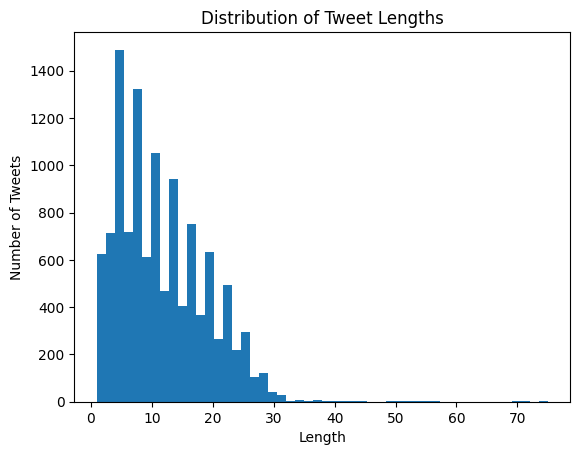

Average length: 11.622237392268964
Median length: 10.0
90th percentile length: 22.0


In [1]:
import pandas as pd
import gensim
import matplotlib.pyplot as plt

data = pd.read_csv('UseThisClean.csv')

# Convert labels to numerical categories if they aren't already
data['Class'] = data['Class'].astype('category').cat.codes

data = data.dropna(subset=['clean_text'])
print(data['clean_text'].isnull().sum())

# Calculate lengths
tweet_lengths = data['clean_text'].apply(lambda x: len(str(x).split()))

# Plot histogram
plt.hist(tweet_lengths, bins=50)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Tweets')
plt.show()

# Print some statistics
print("Average length:", tweet_lengths.mean())
print("Median length:", tweet_lengths.median())
print("90th percentile length:", tweet_lengths.quantile(0.90))


 Loading FastText Embeddings

In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec


--2023-09-01 22:56:05--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610017300 (1.5G) [binary/octet-stream]
Saving to: ‘wiki.ar.vec’

wiki.ar.vec         100%[===================>]   1.50G   134MB/s    in 12s     

2023-09-01 22:56:18 (128 MB/s) - ‘wiki.ar.vec’ saved [1610017300/1610017300]



In [3]:
from gensim.models import KeyedVectors

# Load fasttext model
fasttext_model = KeyedVectors.load_word2vec_format('wiki.ar.vec')

embedding_dim = fasttext_model.vector_size


Data Tokenization and Embedding Matrix Creation

In [4]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 10000  # Only consider top 10k words
max_len = 25  # Only consider the first 25 words of each tweet (Calculated average words of each tweet in previous cell)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['clean_text'])

sequences = tokenizer.texts_to_sequences(data['clean_text'])
word_index = tokenizer.word_index

# Pad sequences
X = pad_sequences(sequences, maxlen=max_len)
y = data['Class'].values

# Splitting data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        if word in fasttext_model:
            embedding_matrix[i] = fasttext_model[word]

Model Architecture

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential()

vocab_size = 10000

# Embedding layer with pre-trained FastText weights
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True, embeddings_regularizer=l2(0.0001)))

# 1st Conv1D, BatchNorm, and MaxPooling1D layers
model.add(Conv1D(32, 5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(4))
model.add(Dropout(0.5))  # Increased dropout

# 2nd Conv1D, BatchNorm, and MaxPooling1D layers
model.add(Conv1D(64, 5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(4))
model.add(Dropout(0.5))  # Increased dropout

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dropout(0.5))

# Final layer
model.add(Dense(3, activation='softmax'))

# Initial learning rate
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping criteria
early_stop_on_loss = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
early_stop_on_accuracy = EarlyStopping(monitor='val_accuracy', patience=1, mode='max', restore_best_weights=True, verbose=1)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 25, 300)           3000000   
                                                                 
 conv1d_7 (Conv1D)           (None, 25, 32)            48032     
                                                                 
 batch_normalization_6 (Batc  (None, 25, 32)           128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 6, 32)             0         
                                                                 
 conv1d_8 (Conv1D)           (None, 6, 64)            

Training

Epoch 1/100
469/469 [==============================] - 41s 81ms/step - loss: 19.1632 - accuracy: 0.3717 - val_loss: 15.7618 - val_accuracy: 0.4368
Epoch 2/100
469/469 [==============================] - 36s 76ms/step - loss: 14.2600 - accuracy: 0.3992 - val_loss: 12.6840 - val_accuracy: 0.5419
Epoch 3/100
469/469 [==============================] - 34s 72ms/step - loss: 11.4887 - accuracy: 0.4741 - val_loss: 10.2545 - val_accuracy: 0.5781
Epoch 4/100
469/469 [==============================] - 36s 77ms/step - loss: 9.2816 - accuracy: 0.5488 - val_loss: 8.2585 - val_accuracy: 0.6176
Epoch 5/100
469/469 [==============================] - 45s 96ms/step - loss: 7.4406 - accuracy: 0.6031 - val_loss: 6.6313 - val_accuracy: 0.6480
Epoch 6/100
469/469 [==============================] - 36s 77ms/step - loss: 5.9472 - accuracy: 0.6495 - val_loss: 5.3362 - val_accuracy: 0.6741
Epoch 7/100
469/469 [==============================] - 35s 75ms/step - loss: 4.7490 - accuracy: 0.7003 - val_loss: 4.3645 - 

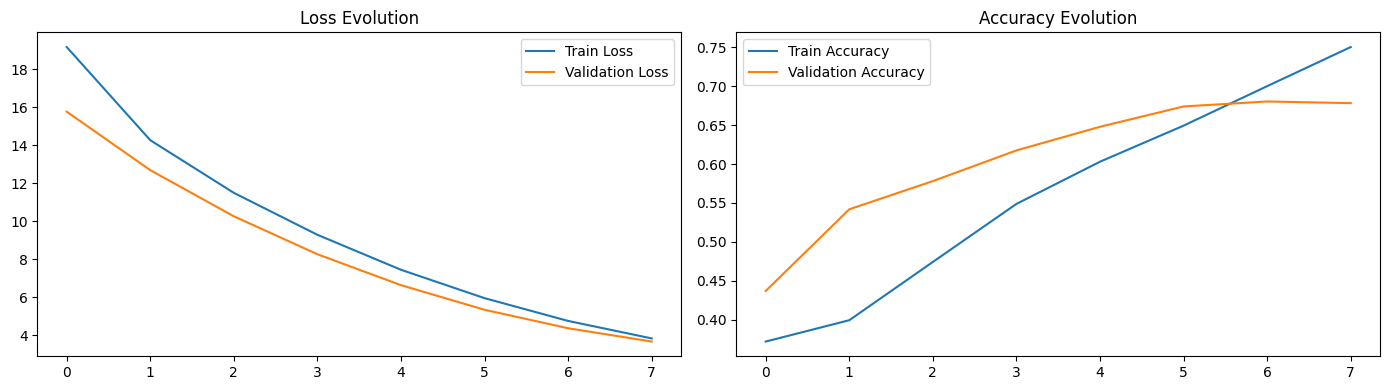

In [19]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, shuffle=True, callbacks = [early_stop_on_loss, early_stop_on_accuracy])

# Visualization of training process
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()


Evaluation

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


74/74 [==============================] - 1s 9ms/step
Accuracy: 0.6680887372013652
Precision: 0.6772918867989425
Recall: 0.6679519144773383
F1 Score: 0.6657148932068249
